In [1]:
%matplotlib inline

# install pillow
!pip install Pillow -U

# download and unzip dataset o train
!wget http://images.cocodataset.org/zips/val2014.zip
!mkdir train
%cd /content/train
!unzip -qq /content/val2014.zip
%cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

     |████████████████████████████████| 4.3 MB 13.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


--2022-04-24 23:44:29--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.224.153
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.224.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  35.9MB/s    in 3m 2s   

2022-04-24 23:47:32 (34.8 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]

/content/train
/content
--2022-04-24 23:48:19--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  29.9MB/s    in 18s     

2022

In [1]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg16_fe as vgg # this is used to extract features
import custom_model
import utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/udnie.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "models/"
SAVE_IMAGE_PATH = "images/out/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [5]:
def train():
    # seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # get the device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # load the training dataset
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # load the models and start training :)
    model = custom_model.CustomModel().to(device)
    vgg16_fe = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device)

    # get style features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    # load the style image
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    # convert style image to tensor
    style_tensor = utils.itot(style_image).to(device)
    # add imagenet mean
    style_tensor = style_tensor.add(imagenet_neg_mean)

    B, C, H, W = style_tensor.shape
    # get the features of the style image
    style_features = vgg16_fe(style_tensor.expand([BATCH_SIZE, C, H, W]))

    # get the gram matrix of the style image
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    # Optimizer settings
    optimizer = optim.Adam(model.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()

    # training loop
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # free up unnecessary memory of cuda
            torch.cuda.empty_cache()

            # zero the gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = model(content_batch)
            content_features = vgg16_fe(content_batch.add(imagenet_neg_mean))
            generated_features = vgg16_fe(generated_batch.add(imagenet_neg_mean))

            # Calculate content loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu2_2'], content_features['relu2_2'])            
            batch_content_loss_sum += content_loss

            # Calculate style loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Calculate total loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(model.state_dict(), checkpoint_path)
                
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0) # clone to save inplace errors
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)
            
            # increment batch count
            batch_count += 1
    
    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    model.eval()
    model.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(model.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)


========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3213490.00
	Style Loss:	20187028.00
	Total Loss:	23400518.00
Time elapsed:	0.2940709590911865 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_0.pth
Saved sample tranformed image at images/out/sample0_0.png
========Iteration 501/10126========
	Content Loss:	2364541.75
	Style Loss:	2781679.73
	Total Loss:	5146223.18
Time elapsed:	86.04039740562439 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_500.pth
Saved sample tranformed image at images/out/sample0_500.png
========Iteration 1001/10126========
	Content Loss:	1925167.88
	Style Loss:	1824119.61
	Total Loss:	3749287.81
Time elapsed:	171.23831391334534 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_1000.pth
Saved sample tranformed image at images/out/sample0_1000.png
========Iteration 1501/10126========
	Content Loss:	1661690.12
	Style Loss:	1457368.70
	Total Loss:	3119060.54
Time elapsed:	257.5747

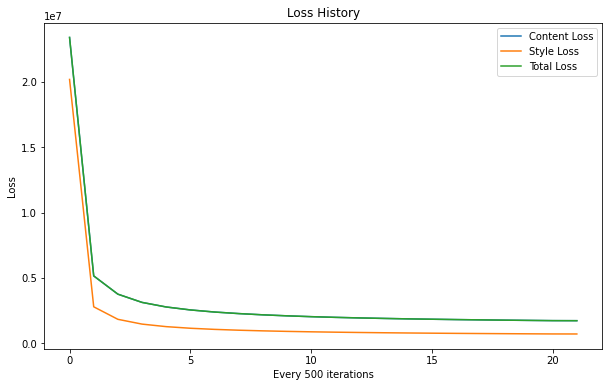

In [6]:
train()

In [11]:
# copy the models folder to the folder in the google drive
!cp -r models/ /content/gdrive/My\ Drive/models/
# copy the images folder to the folder in the google drive
!cp -r images/ /content/gdrive/My\ Drive/images/